In [1]:
import os
os.chdir('run-cem-pymt')
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('coastal2025/scripts')  # Path relative to the notebook
import cem_utils as utils

In [2]:
import numpy as np
#xy = np.loadtxt('lejeune_2015.txt')
xy = np.loadtxt('portsmouth_2003.txt')

# shoreline
xy = xy[::2,:]
x,y = [xy[:,col] for col in range(xy.shape[1])]

In [3]:
res = np.hypot(x[1:]-x[:-1],y[1:]-y[:-1]).mean().round()
print(res)

100.0


In [4]:
dx=int(res)
dy=int(res)#50

# Get the sorted indices of x
sorted_indices = np.argsort(x)

# Sort x and reorder y accordingly
x_sorted = np.array([x[j] for j in sorted_indices])#x[sorted_indices]
y_sorted = np.array([y[j] for j in sorted_indices])#y[sorted_indices]

xnew,ynew,angle = utils.rotate_shoreline(x_sorted,y_sorted)

In [5]:
angle

-53.76990053610242

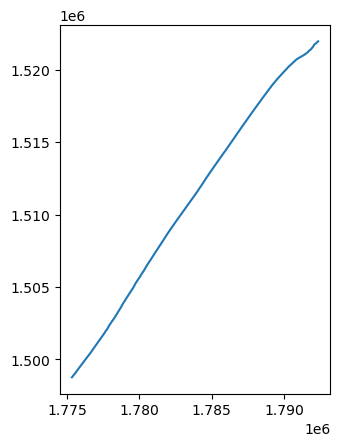

In [6]:
from matplotlib import pyplot as plt
plt.plot(x,y)
plt.gca().set_aspect('equal')

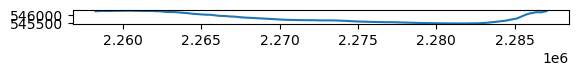

In [7]:
# TODO: Check that sorted points keep seaward direction towards top of screen
# North Core Banks needs flipping
flip = -1
plt.plot(xnew,flip*ynew)
plt.gca().set_aspect('equal')

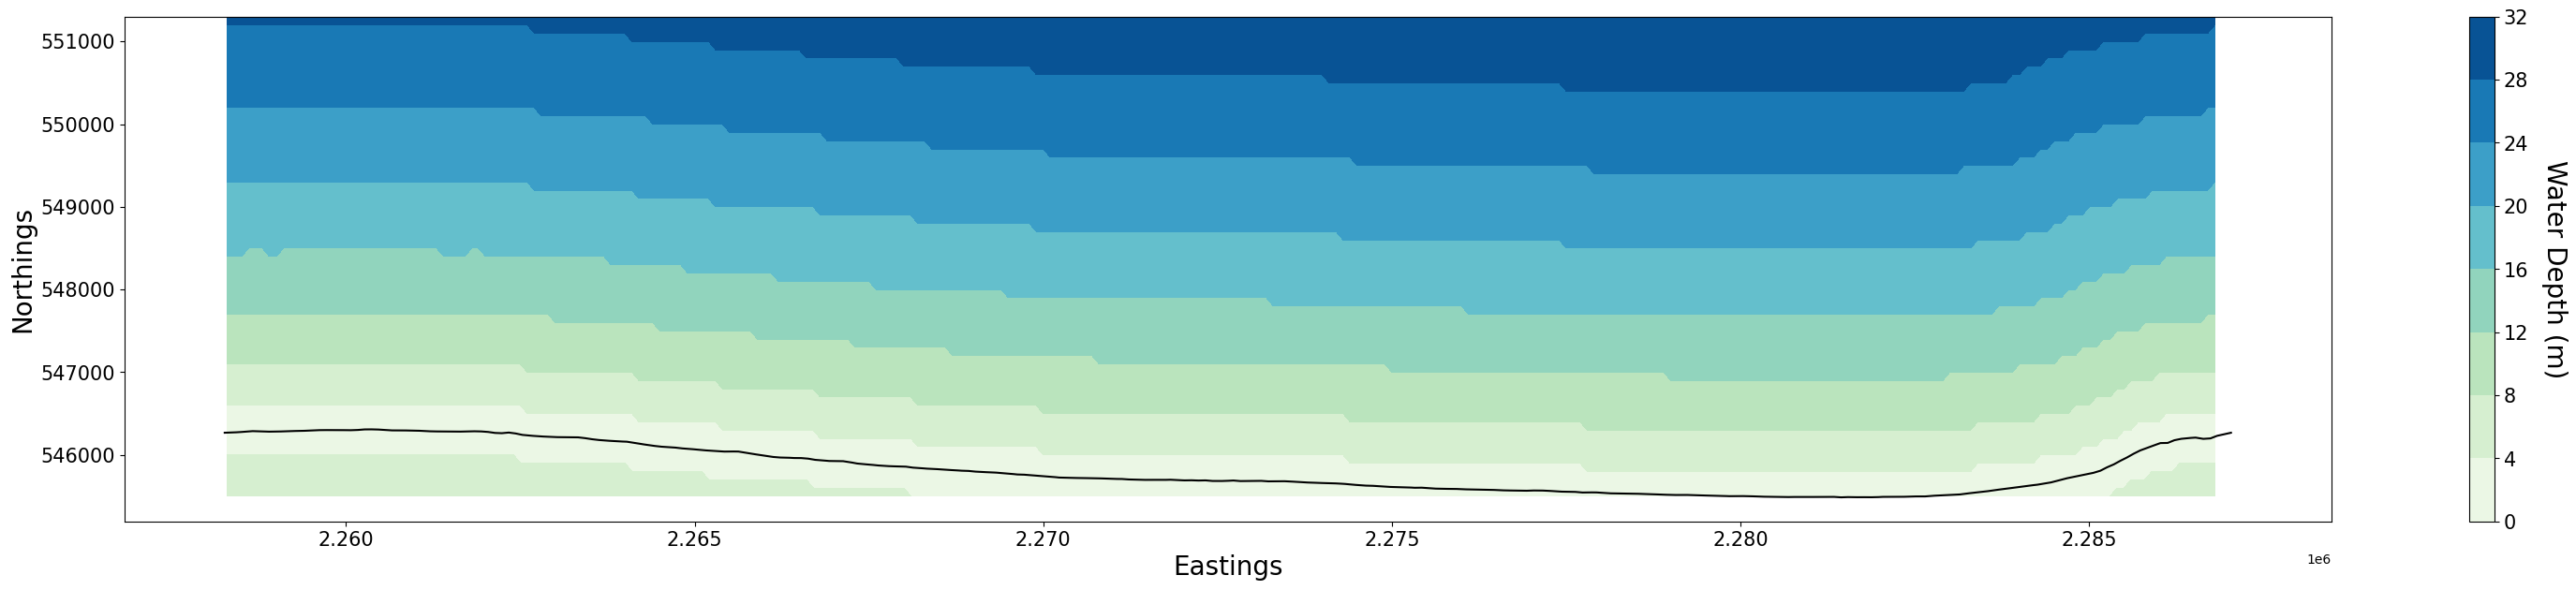

In [8]:
xf, yf = utils.fill_gaps(xnew, flip*ynew, 50)

[xg,yg,elev] = utils.shorelinetogrid(xf,yf,dx,dy,plotdata=True)

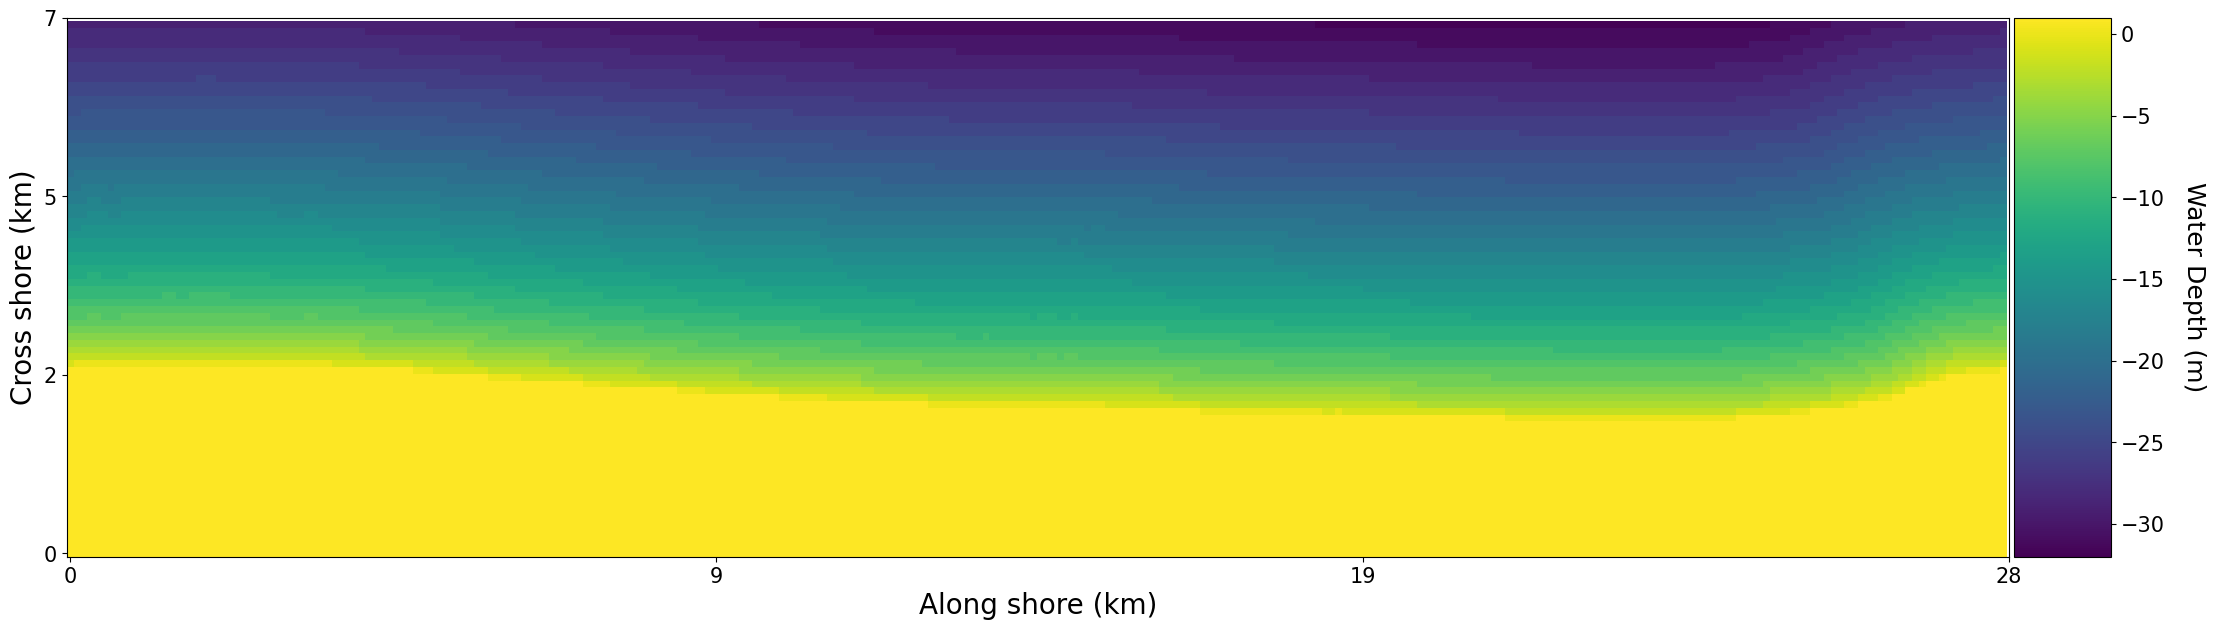

In [9]:
pad = 20
# we need pad to be the masked values
domain = utils.set_domain(elev, pad=pad)
# Also pad the sides by the inlet and outlet bdys
#domain = np.repeat(domain,[pad,*np.ones(domain.shape[1]-2),pad],axis=1)
# visualize updated coastline data
utils.plot_coast(domain,dx,dy)

In [10]:
shelf_slope = utils.find_shelf_slope(domain, dx) ##This should be on the order of 0.001. If not you may need to find this manually
print(shelf_slope)
# estimation of shoreface parameters:
shoreface_slope = 4*shelf_slope ## the shoreface is steeper than the shelf
print(shoreface_slope)
shoreface_depth = 10 # depth meters
print(shoreface_depth)

0.004044226502402301
0.016176906009609204
10


In [11]:
Hs,Tp,A,U = (2, 8, 0.5, 0.5)

### 9b. Initialize and Run Model

In [12]:
from pymt.models import Cem, Waves
cem = Cem()
waves = Waves()

#convert wave direction to asymmetry term
params = {
    
    ## CEM 
    'grid_spacing'    : dx,                #meters
    'shelf_slope'     : shelf_slope,
    'shoreface_depth' : shoreface_depth,   #meters
    'shoreface_slope' : shoreface_slope,
    'model__time_step': 1,               #days
    
    ##WAVES
    'wave_height' : Hs, #meters
    'wave_period' : Tp, #seconds
    'wave_angle_highness': U, #important param
    'wave_angle_asymmetry': A
    
}

Setting end time to 3650
CEM: trying to open file: cem.txt
CEM: line: 79, 286, 100, 1

CEM: number of rows, columns: 79, 286
*** Grid size is (0,0)
*** Requested size is (79,572)
*** New grid size is (79,572)
/opt/tljh/user/envs/pymt-cem/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


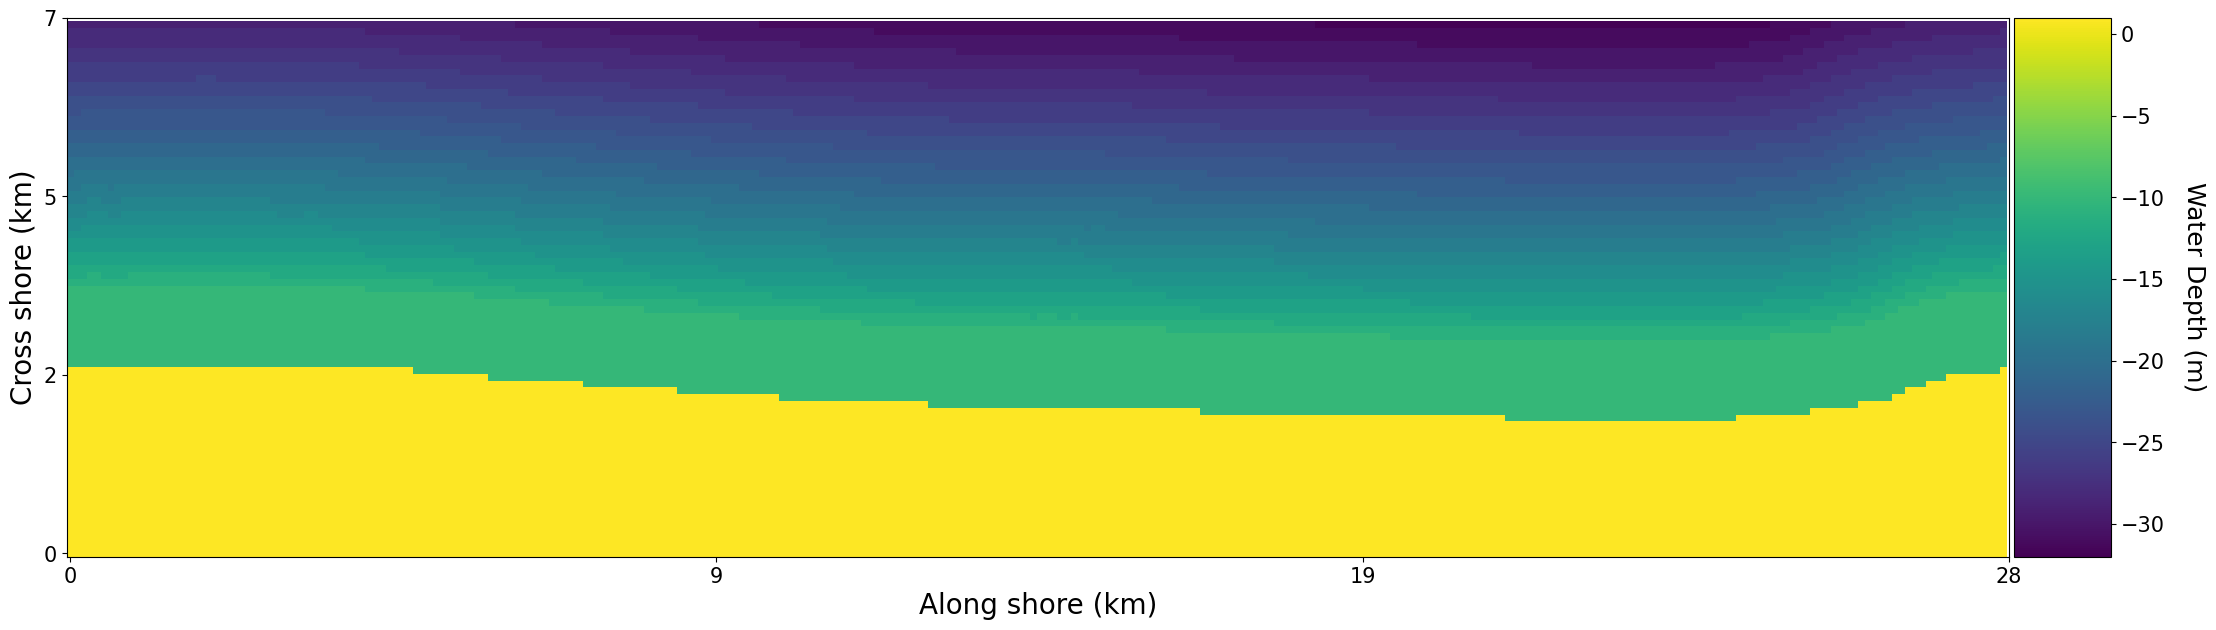

In [13]:
utils.initialize_models(params,domain,cem,waves,set_land=True)
land = cem.get_value('land_surface__elevation')
land = land.reshape(  domain.shape  )
#plot_coast(domain,dx,dy)
utils.plot_coast(land,dx,dy)

In [14]:
## inputs: time_years, qs_vec (kg/s) - bedload sediment input from a spit
time_years=10
T = 365*(time_years/cem.get_value('model__time_step')).astype('int').item()
qs_vec = np.linspace(400,700,T)
n,m = domain.shape
qs_3 = np.zeros((n,m,T))
# qs_3[20,27,:] = qs_vec


In [15]:
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
# plot
#utils.run_model_loop(time_years, domain ,cem ,waves, qs_3,animate=True,update_ani_years=1)
anim = utils.vid_model_loop(time_years, domain ,cem ,waves, qs_3, True, 1)#/2, png_dir)
anim.save('portsmouth.gif', writer="pillow")

xtest is uninitialized!ytest is uninitialized!

In [16]:
anim